# **Generating Snowman (Olaf) Images - GAN**

In [ ]:
import torch
from torch import FloatTensor, LongTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((150, 150)),
        transforms.Normalize(mean = (0.5), std = (0.5))
    ]
)

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d sayehkargari/disney-characters-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 591M/609M [00:05<00:00, 102MB/s]
100% 609M/609M [00:05<00:00, 111MB/s]


In [ ]:
! unzip /content/disney-characters-dataset.zip

Archive:  /content/disney-characters-dataset.zip
  inflating: cartoon/test/donald/127-1276467_donald-duck-clipart-mad-donald-duck-angry-clipart.png  
  inflating: cartoon/test/donald/129-1297602_donald-and-daisy-duck-clipart-disney-donald-duck.png  
  inflating: cartoon/test/donald/131-1311869_disney-clip-art-galore-donald-donald-duck-halloween.png  
  inflating: cartoon/test/donald/145-1454915_donald-duck-clipart-mad-done-with-cold-weather.png  
  inflating: cartoon/test/donald/165-1658446_coolest-mad-face-clipart-donald-duck-face-png.png  
  inflating: cartoon/test/donald/172-1723337_donald-duck-disney-donald-duck-clipart-hd-png.png  
  inflating: cartoon/test/donald/184-1840564_donald-duck-clipart-disney-donald-duck-logo.png  
  inflating: cartoon/test/donald/184-1840624_baby-donald-duck-donald-duck-disney-duck-images.png  
  inflating: cartoon/test/donald/191-1916983_bowtie-clipart-donald-duck-disney-baby-donald-duck.png  
  inflating: cartoon/test/donald/191-1916983_bowtie-clipart

In [ ]:
! rm -rf /content/cartoon/train/donald /content/cartoon/train/mickey
! rm -rf /content/cartoon/train/minion /content/cartoon/train/pooh
! rm -rf /content/cartoon/train/pumba

In [ ]:
data = ImageFolder(root = "/content/cartoon/train", transform = transform)
data

Dataset ImageFolder
    Number of datapoints: 604
    Root location: /content/cartoon/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               Normalize(mean=0.5, std=0.5)
           )

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

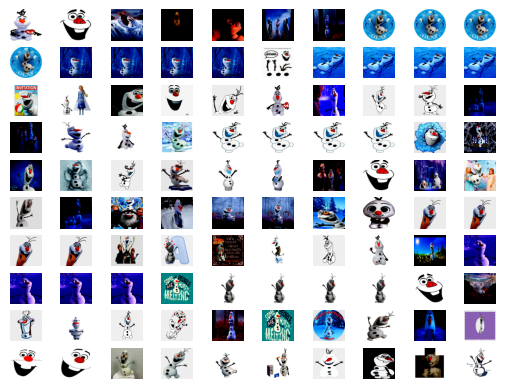

In [ ]:
fig = plt.figure()

for i in range(100):
  fig.add_subplot(10, 10, i + 1)
  plt.imshow(data[i][0].permute(1, 2, 0))
  plt.axis("off")

In [ ]:
data_loader = DataLoader(data, batch_size = 25, shuffle = True)

In [ ]:
import torch.nn as nn

In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 2, padding = 0),
        nn.ReLU(),

        nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5, stride = 2, padding = 0 ),
        nn.ReLU(),

        nn.Flatten(),

        nn.Linear(12 * 35 * 35, 256),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Linear(256, 128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Linear(128, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
latent_dim = 200

class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Linear(128, 3 * 150 * 150),
        nn.Tanh()
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [50]:
loss_fn = nn.BCELoss()

optim_g = torch.optim.Adam(generator.parameters(), lr = 0.0007)
optim_d = torch.optim.Adam(discriminator.parameters(), lr = 0.0007)

In [51]:
import os
from torchvision.utils import save_image

In [56]:
epochs = 50

for epoch in range(epochs):
  for b, (real_imgs, _) in enumerate(data_loader):
    if b == 24:
      continue

    real_imgs = real_imgs.to(device)

    real_labels = torch.ones(25, 1).to(device)
    fake_labels = torch.zeros(25, 1).to(device)

    # Training -> Generator
    x = torch.randn(25, 200).to(device)
    fake_imgs = generator(x).view(-1, 3, 150, 150)
    g_loss = loss_fn(discriminator(fake_imgs), real_labels)
    optim_g.zero_grad()
    g_loss.backward()
    optim_g.step()

    # Training -> Discriminator
    d_loss_real = loss_fn(discriminator(real_imgs), real_labels)
    d_loss_fake = loss_fn(discriminator(fake_imgs.detach()), fake_labels)
    d_loss = (d_loss_real + d_loss_fake) / 2
    optim_d.zero_grad()
    d_loss.backward()
    optim_d.step()

    if (b + 1) % 10 == 0:
            print(f"[Epoch {epoch + 1}] [Batch {b + 1}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

  # Save generated images
  os.makedirs("Image", exist_ok=True)
  save_image(fake_imgs.view(fake_imgs.size(0), 3, 150, 150), f"Image/{epoch + 1}.png", normalize = True)


[Epoch 1] [Batch 10] [D loss: 0.005087512079626322] [G loss: 5.42122745513916]
[Epoch 1] [Batch 20] [D loss: 0.00018301037198398262] [G loss: 9.611897468566895]
[Epoch 2] [Batch 10] [D loss: 0.008481177501380444] [G loss: 9.105643272399902]
[Epoch 2] [Batch 20] [D loss: 0.0010547247948125005] [G loss: 6.83502197265625]
[Epoch 3] [Batch 10] [D loss: 6.00616040173918e-05] [G loss: 9.380202293395996]
[Epoch 3] [Batch 20] [D loss: 0.01981787383556366] [G loss: 3.630643844604492]
[Epoch 4] [Batch 10] [D loss: 0.00015165464719757438] [G loss: 8.284563064575195]
[Epoch 4] [Batch 20] [D loss: 0.0018740220693871379] [G loss: 6.09564208984375]
[Epoch 5] [Batch 10] [D loss: 0.0009687212877906859] [G loss: 6.424515724182129]
[Epoch 5] [Batch 20] [D loss: 0.0009686947450973094] [G loss: 8.325602531433105]
[Epoch 6] [Batch 10] [D loss: 0.0008038574014790356] [G loss: 6.540124416351318]
[Epoch 6] [Batch 20] [D loss: 0.0007987545686773956] [G loss: 6.7764763832092285]
[Epoch 7] [Batch 10] [D loss: 0.0

## **Generated Images**

In [57]:
from PIL import Image

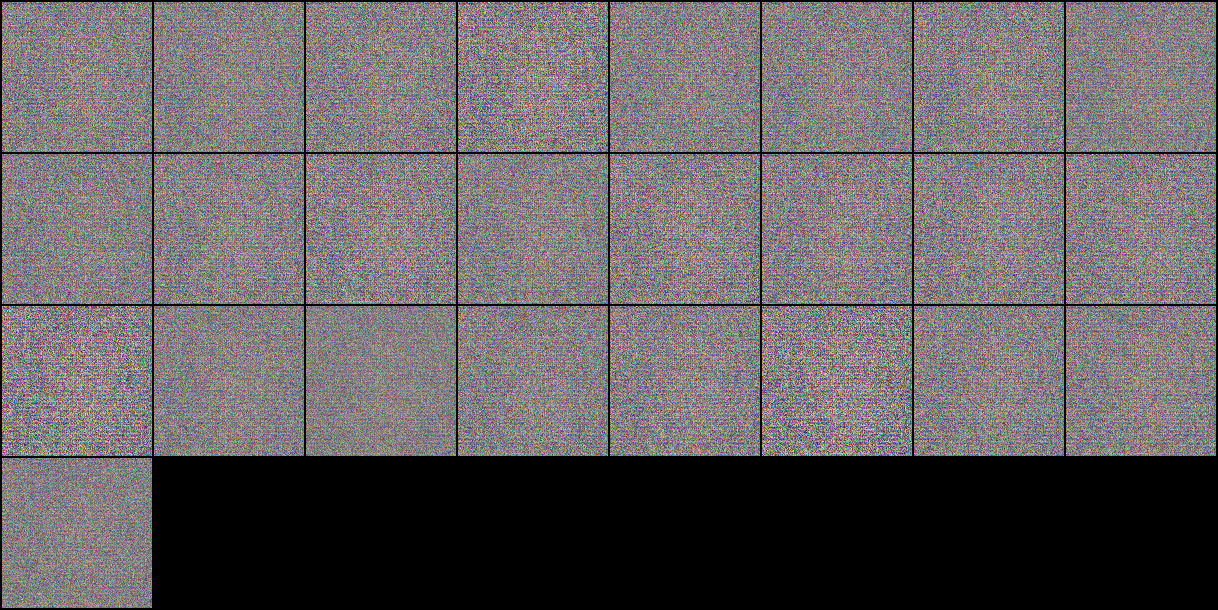

In [58]:
# Generated Images - Epoch 1
Image.open("image/1.png")

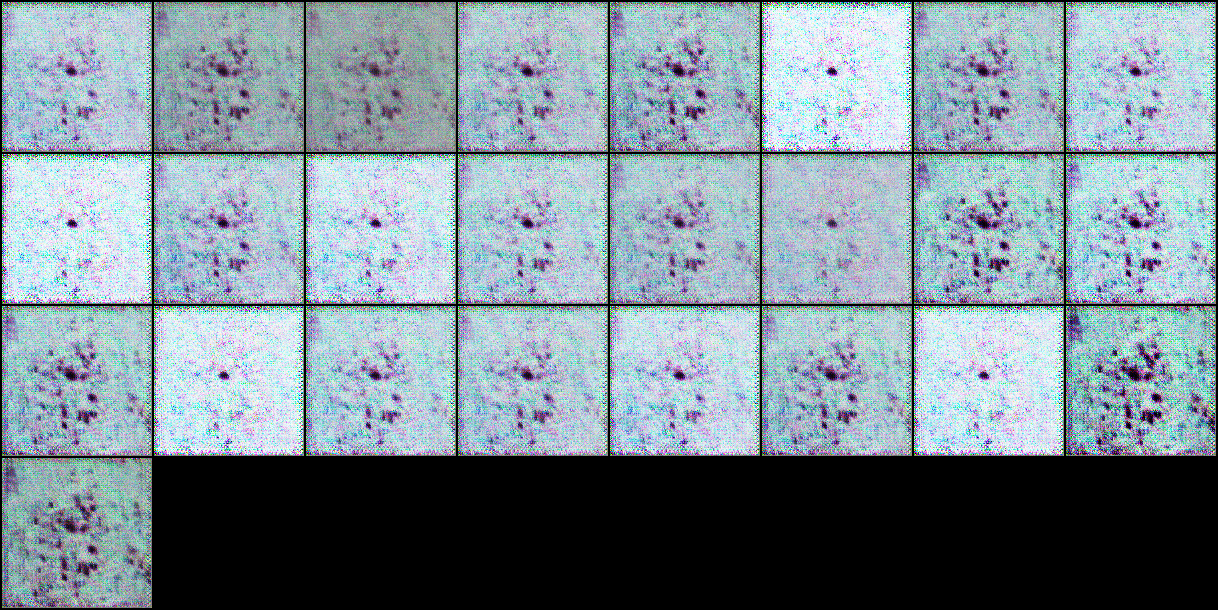

In [59]:
# Generated Images - Epoch 62
Image.open("images/12.png")

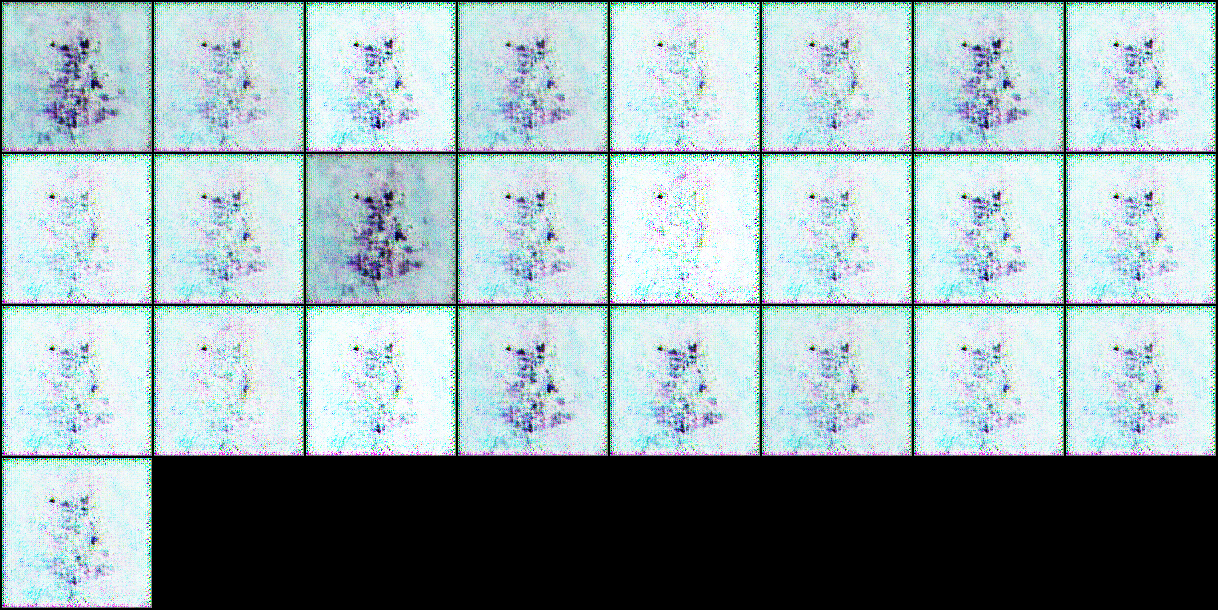

In [63]:
# Generated Images - Epoch 134
Image.open("Images/34.png")

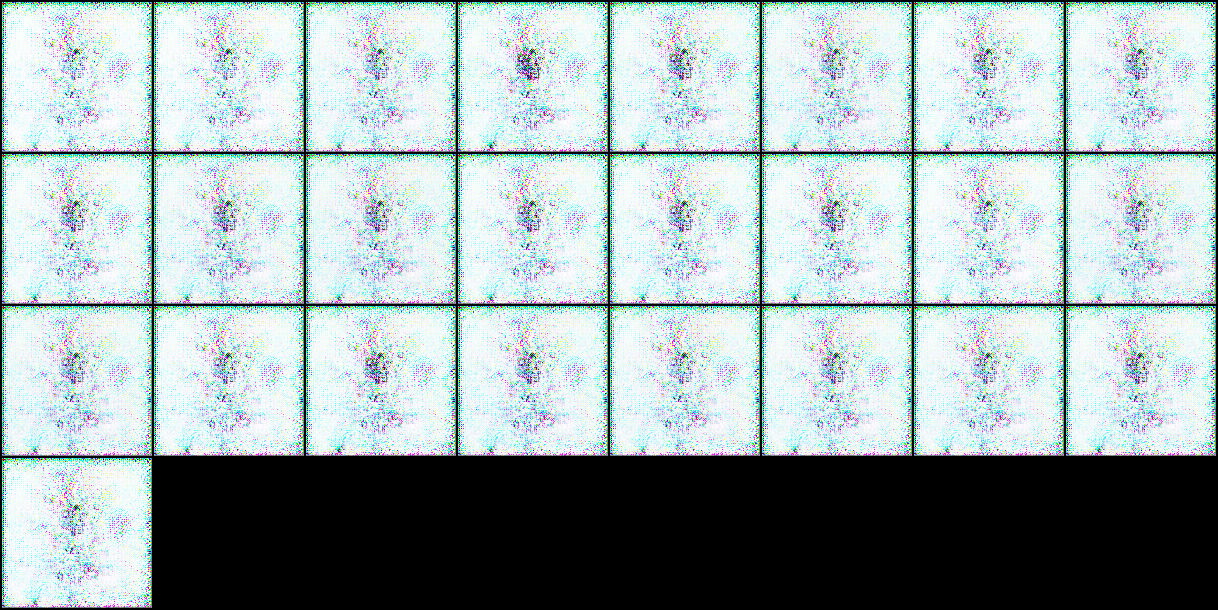

In [80]:
# Generated Images - Epoch 177
Image.open("Image/27.png")